In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import matplotlib.dates as mdates

In [ ]:
def read_csv_data(filepath):
    data = pd.read_csv(filepath, parse_dates=['Local time'], dayfirst=True)
    data = data.set_index('Local time')
    return data

In [ ]:
def calculate_indicators(data, window):
    data['SMA'] = data['Close'].rolling(window=window).mean()
    data['StdDev'] = data['Close'].rolling(window=window).std()
    data['Upper Band'] = data['SMA'] + (data['StdDev'] * 2)
    data['Lower Band'] = data['SMA'] - (data['StdDev'] * 2)
    return data

def clean_data(data):
    data.dropna(inplace=True)
    return data

def generate_signals(data, trading_costs, take_profit_percentage):
    buy_signals = np.zeros(len(data), dtype=bool)
    sell_signals = np.zeros(len(data), dtype=bool)
    take_profit_signals = np.zeros(len(data), dtype=bool)
    cumulative_profit = np.zeros(len(data))
    trade_dates = []
    returns = [0]*len(data)
    wait_for = 'buy'
    last_buy_price = None

    for i in range(1, len(data)):
        cumulative_profit[i] = cumulative_profit[i-1]

        if wait_for == 'buy' and data['Close'].iloc[i] < data['Lower Band'].iloc[i]:
            buy_signals[i] = True
            last_buy_price = data['Close'].iloc[i] * (1 + trading_costs)
            wait_for = 'sell'

        if wait_for == 'sell':
            daily_return = data['Close'].iloc[i] - data['Close'].iloc[i - 1]
            returns[i] = daily_return
            cumulative_profit[i] += daily_return
            if last_buy_price is not None and data['Close'].iloc[i] >= last_buy_price * (1 + take_profit_percentage):
                take_profit_signals[i] = True
                sell_price = data['Close'].iloc[i] * (1 - trading_costs)
                trade_dates.append(data.index[i])
                wait_for = 'buy'
            elif data['Close'].iloc[i] > data['Upper Band'].iloc[i]:
                sell_signals[i] = True
                if last_buy_price is not None:
                    sell_price = data['Close'].iloc[i] * (1 - trading_costs)
                    trade_dates.append(data.index[i])
                wait_for = 'buy'

    return data, buy_signals, sell_signals, take_profit_signals, cumulative_profit, trade_dates, returns

def plot_signals(data, buy_signals, sell_signals, take_profit_signals, title):
    plt.figure(figsize=(24, 7))
    plt.plot(data.index, data['Close'], label='Close Price', color='blue')
    plt.plot(data.index, data['Upper Band'], label='Upper Band', linestyle='--', color='red')
    plt.plot(data.index, data['Lower Band'], label='Lower Band', linestyle='--', color='green')
    plt.plot(data.index, data['SMA'], label='SMA', linestyle='-', color='gray')
    plt.plot(data.index[buy_signals], data['Close'][buy_signals], '^', markersize=10, color='g', lw=0, label='Buy Signal')
    plt.plot(data.index[sell_signals], data['Close'][sell_signals], 'v', markersize=10, color='r', lw=0, label='Sell Signal')
    plt.plot(data.index[take_profit_signals], data['Close'][take_profit_signals], '*', markersize=10, color='gold', lw=0, label='Take Profit Signal')
    plt.xlim(data.index.min(), data.index.max())
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_profits(data, cumulative_profits, title):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, cumulative_profits, label='Cumulative Profit', color='purple')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Profit ($)')
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
def read_and_calculate_indicators(file_path,window):
    data = read_csv_data(file_path)
    data = calculate_indicators(data,window)
    return data

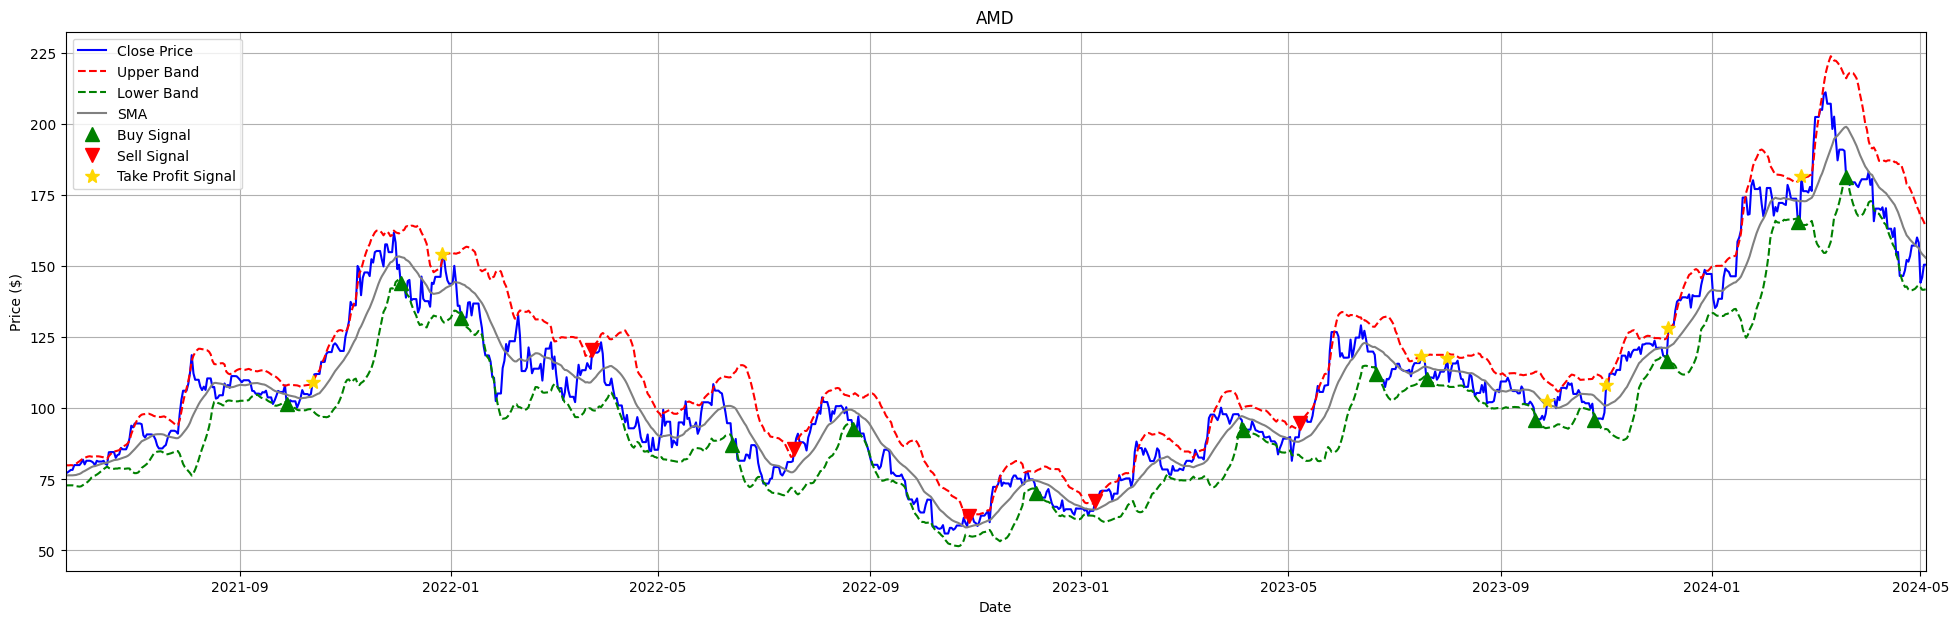

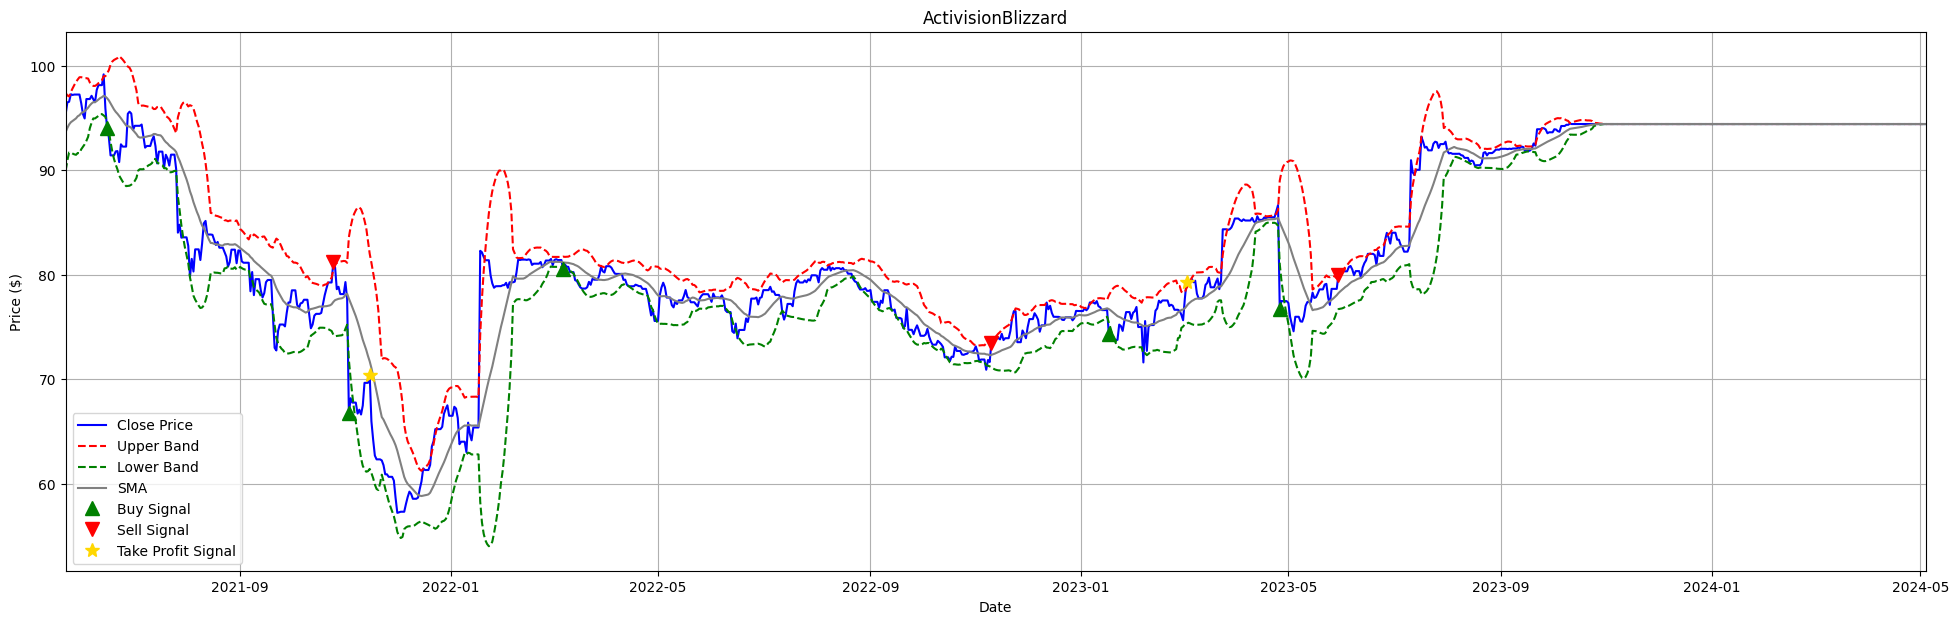

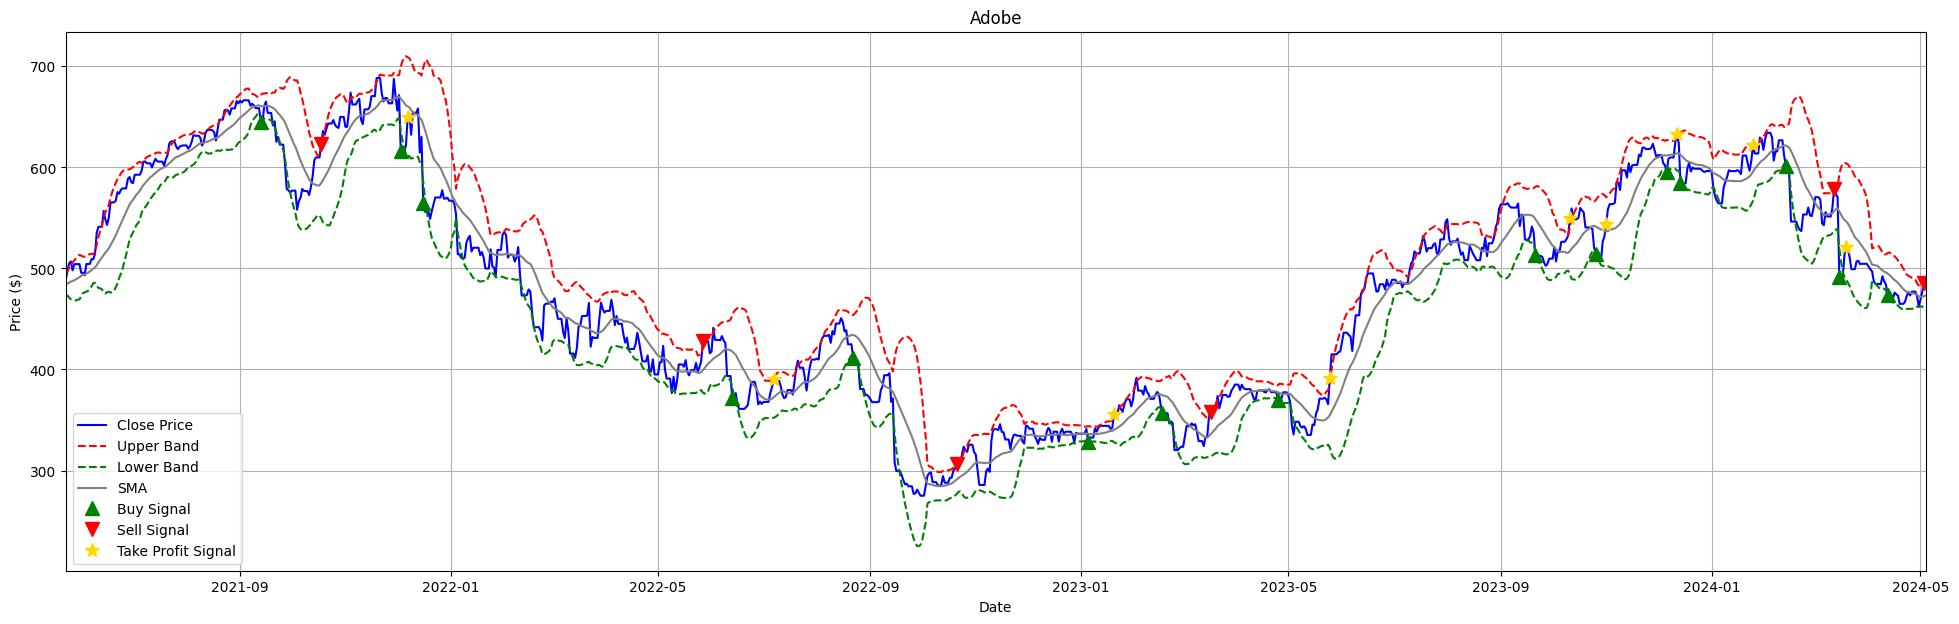

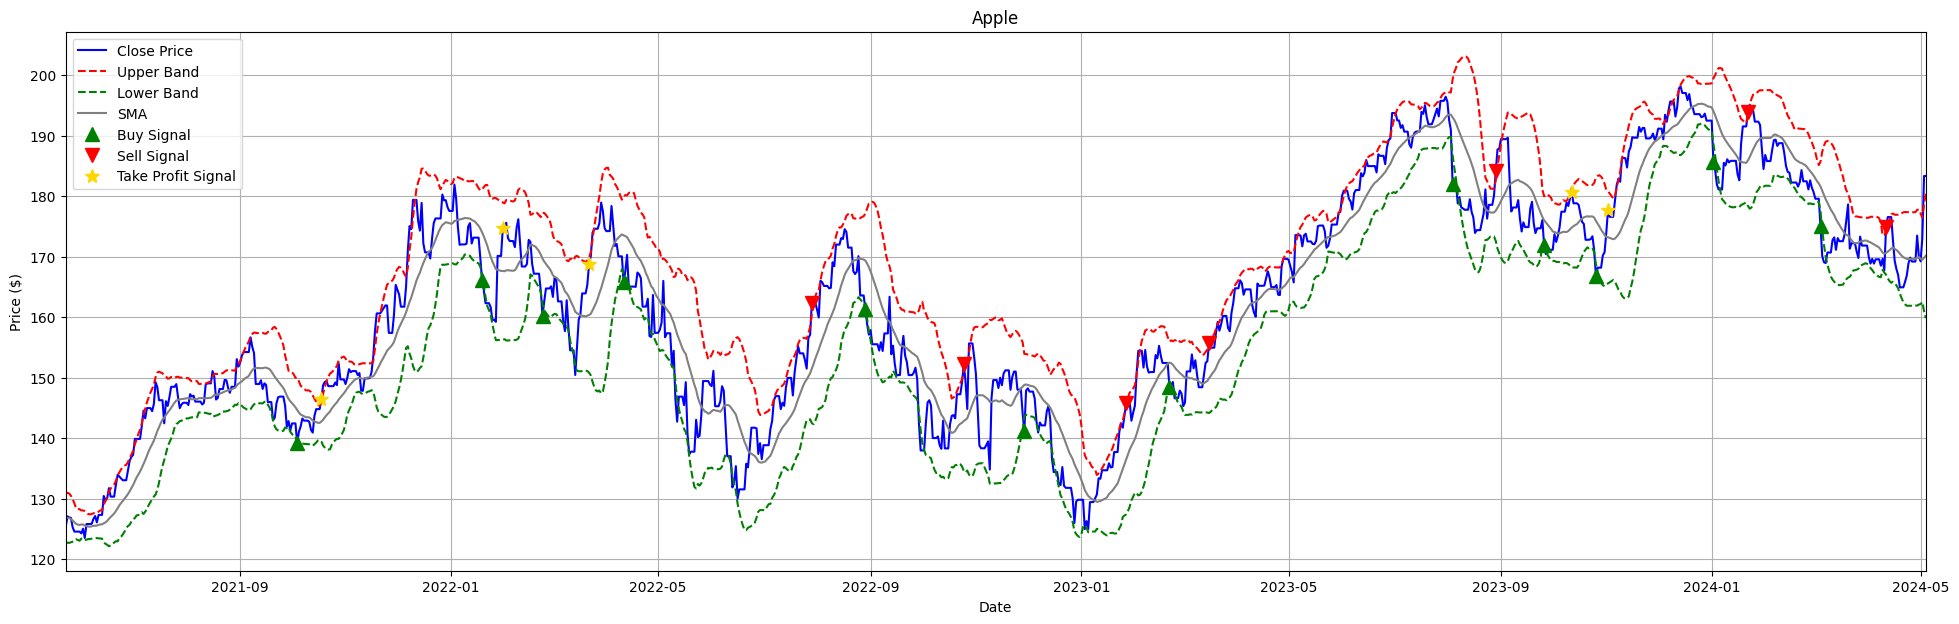

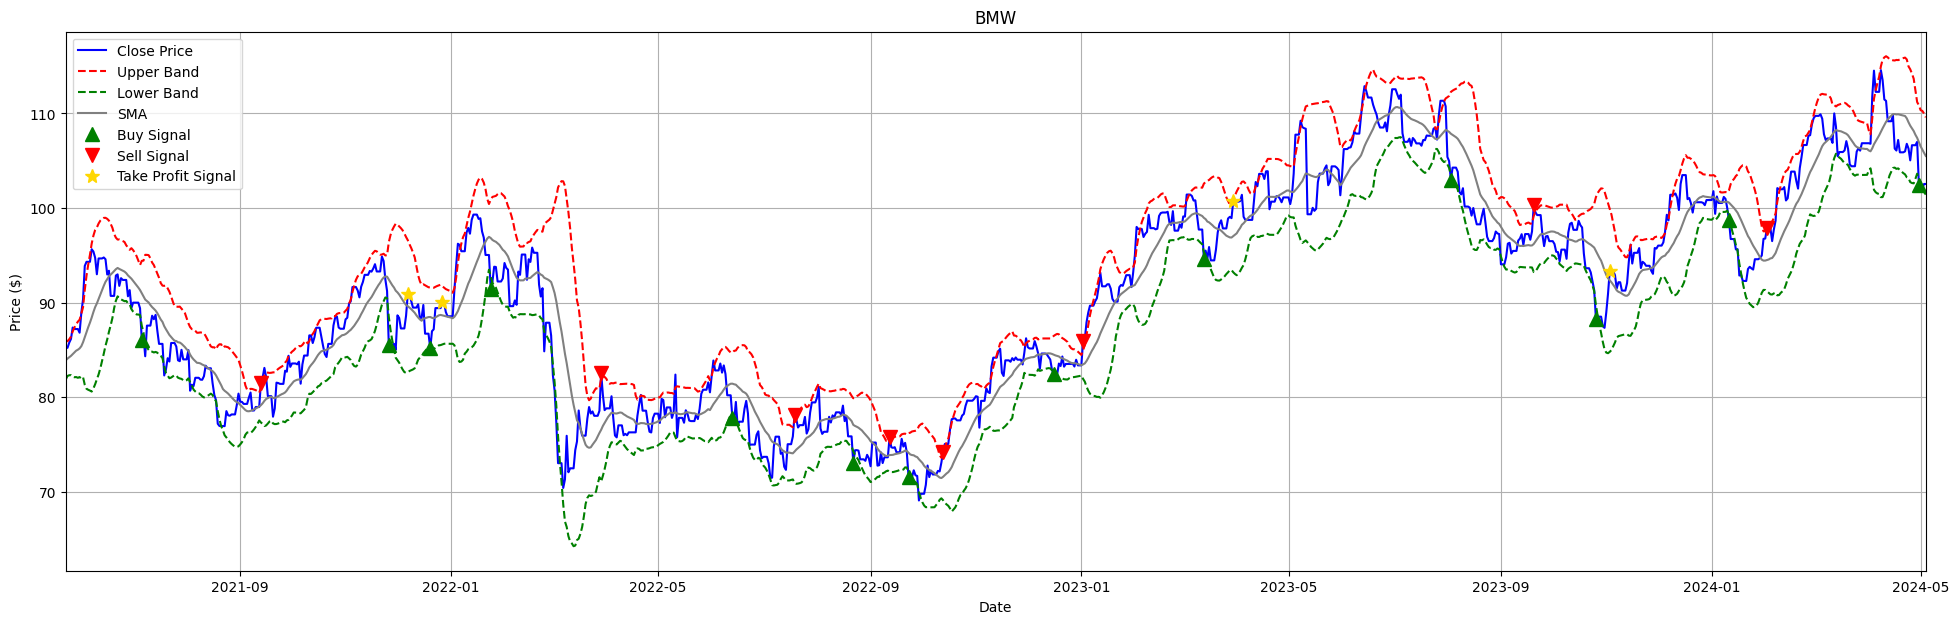

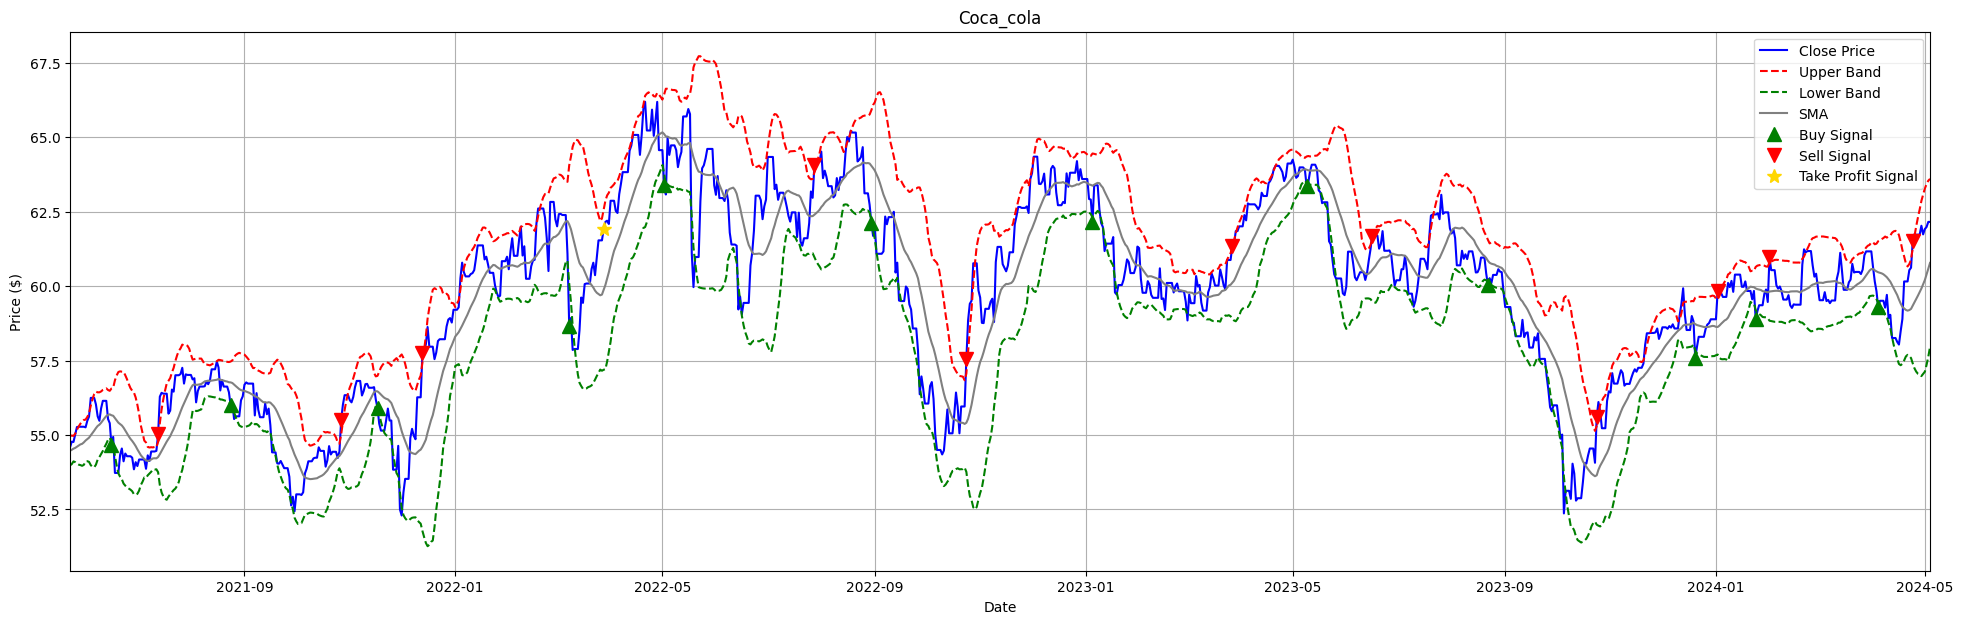

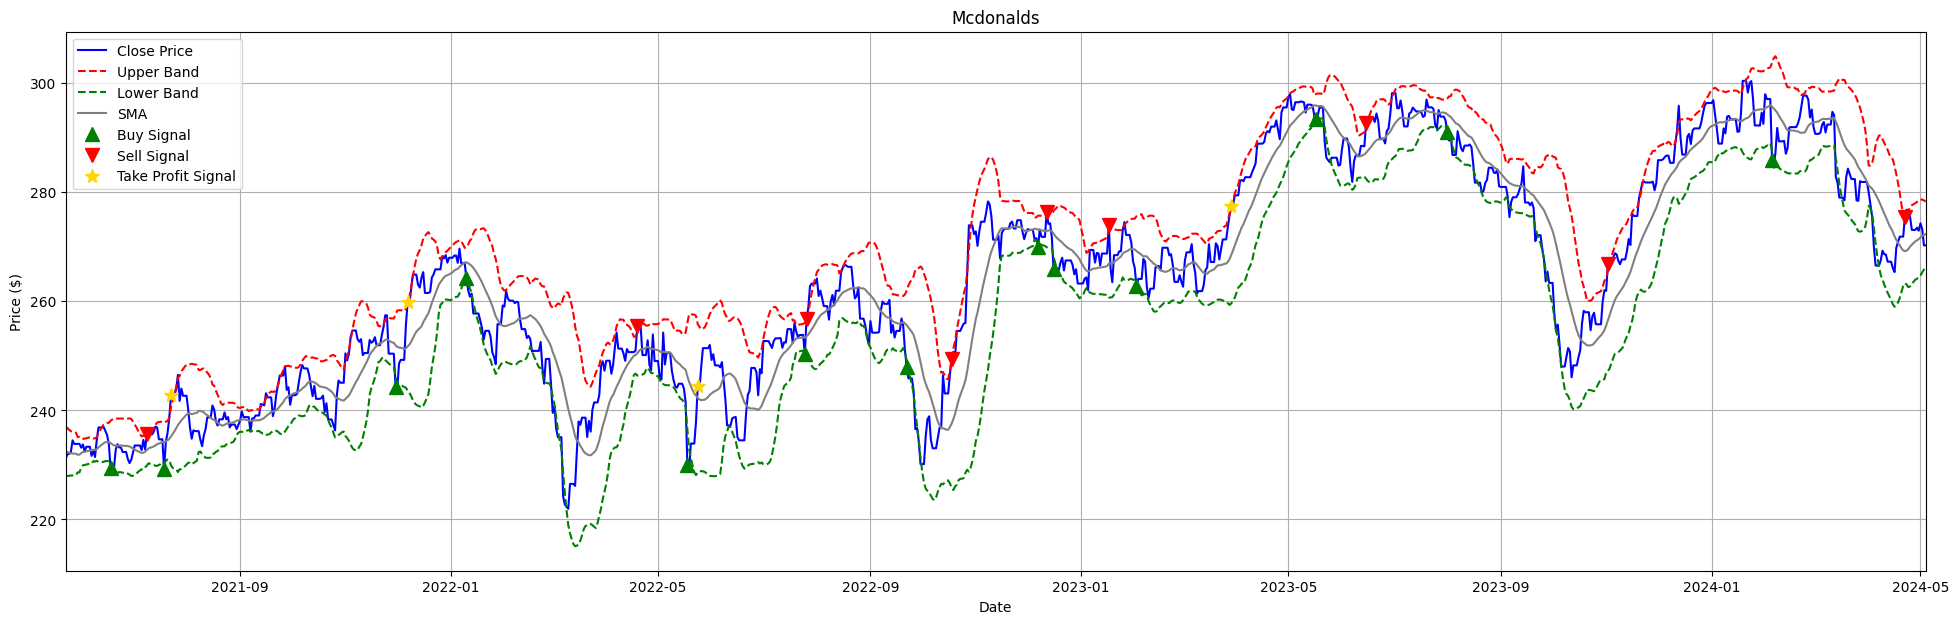

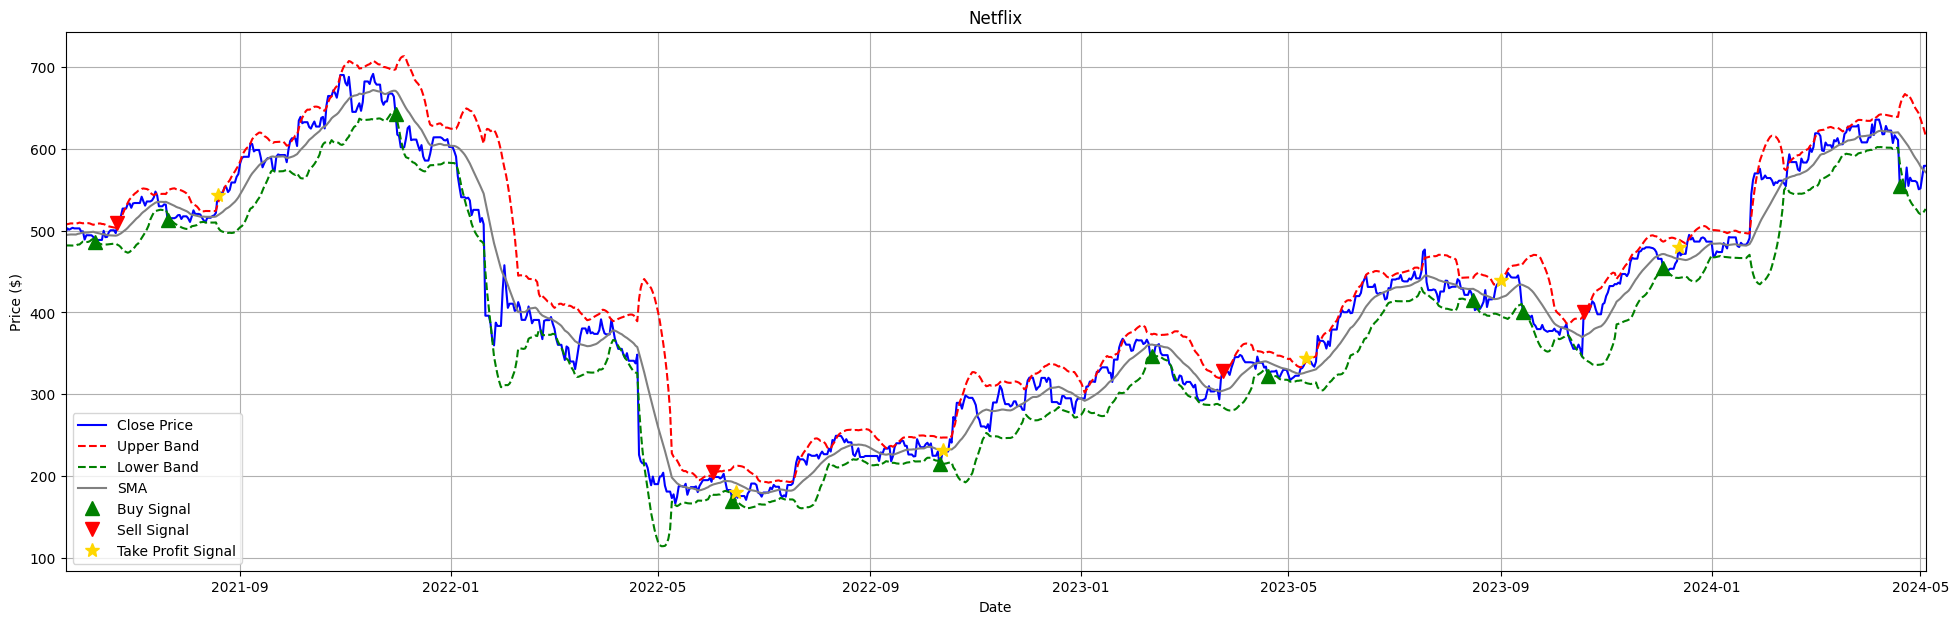

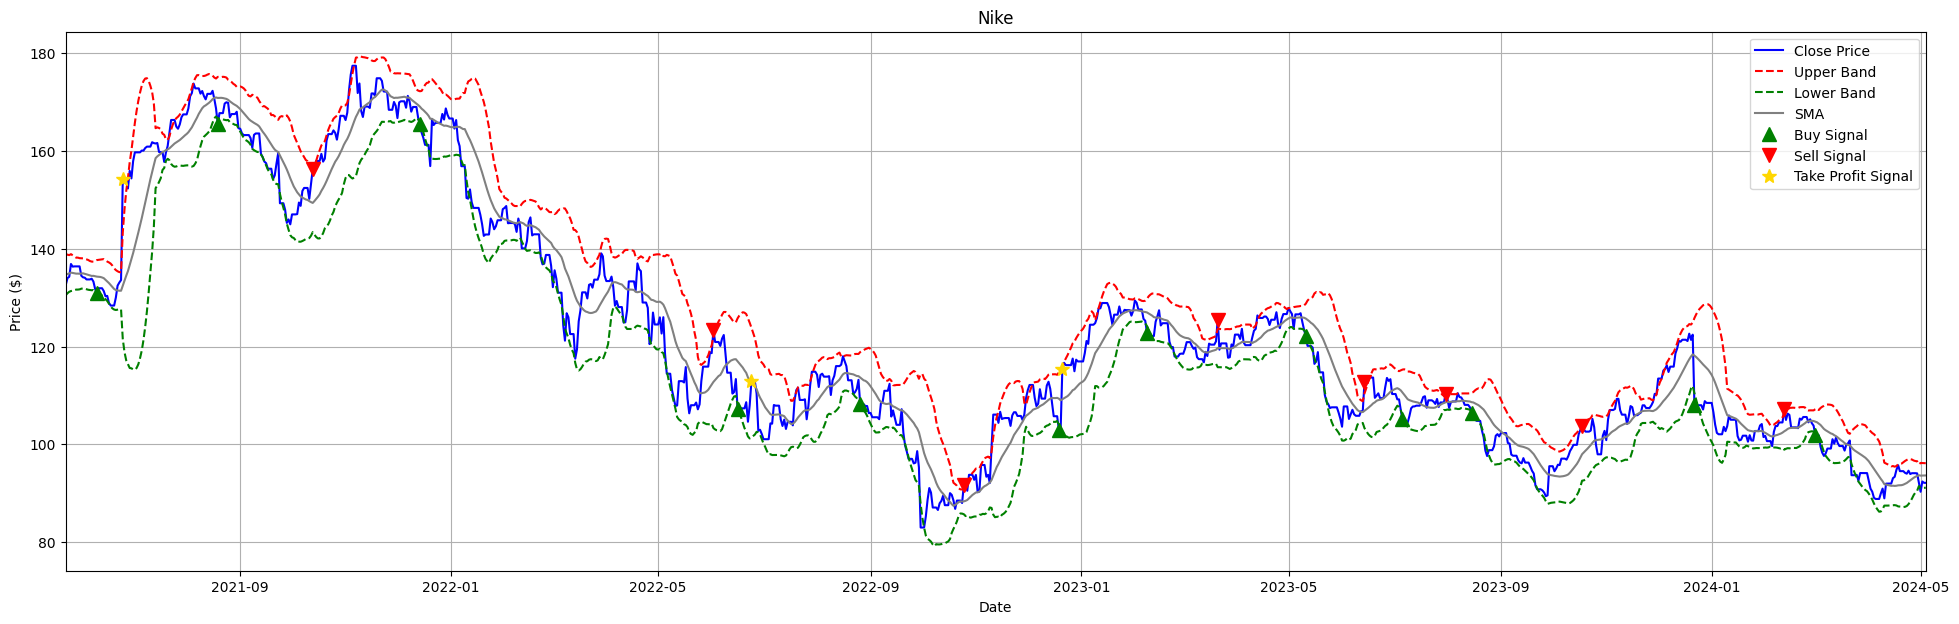

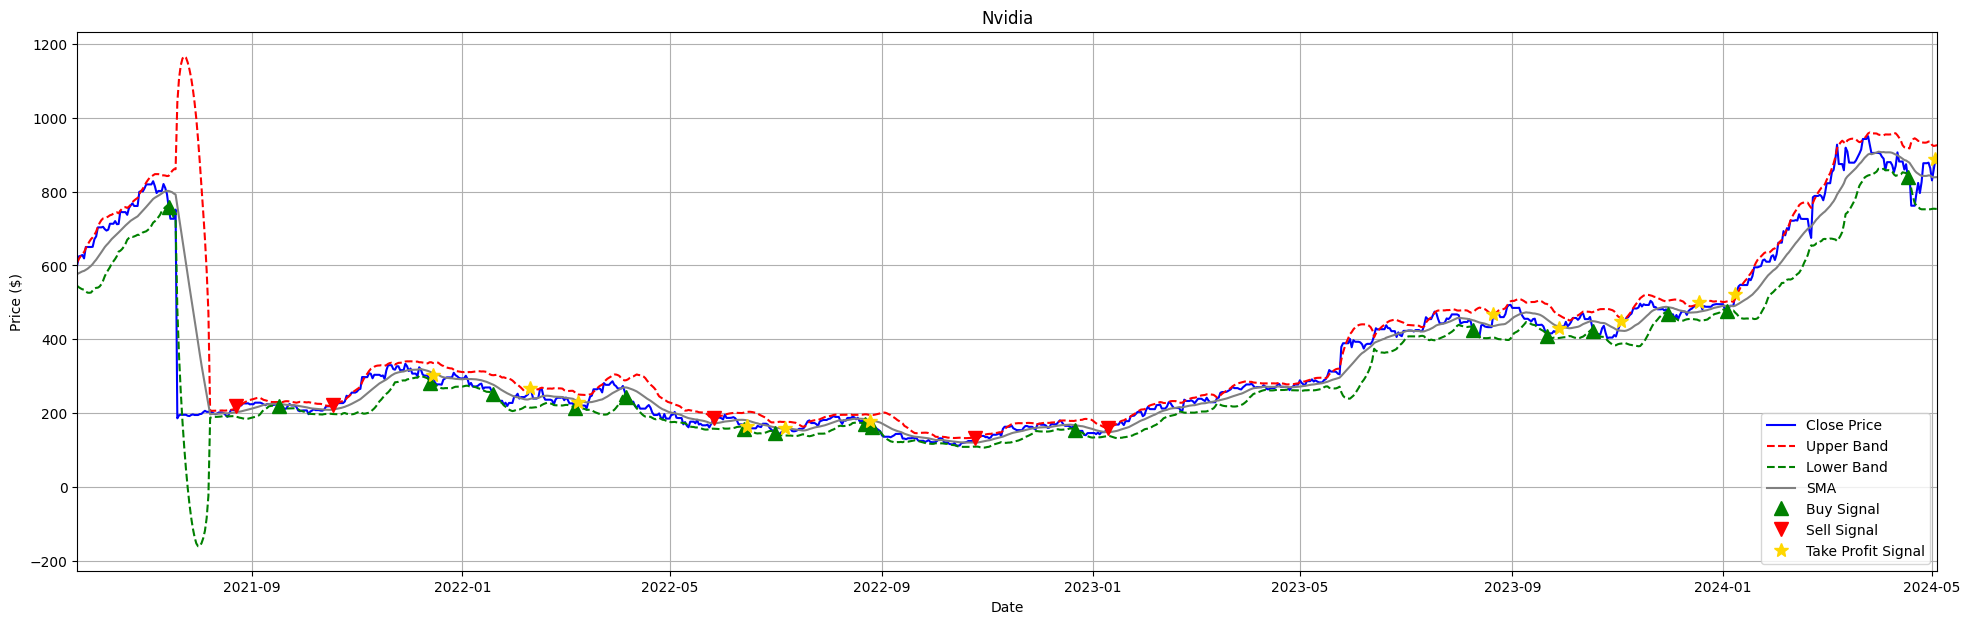

In [ ]:
file_paths = [ '/content/AMD.csv',
               '/content/ActivisionBlizzard.csv',
               '/content/Adobe.csv',
               '/content/Apple.csv',
               '/content/BMW.csv',
               '/content/Coca_cola.csv',
               '/content/Mcdonalds.csv',
               '/content/Netflix.csv',
               '/content/Nike.csv',
               '/content/Nvidia.csv']

for i, file_path in enumerate(file_paths):

    file_name = os.path.splitext(os.path.basename(file_path))[0]
    data = read_and_calculate_indicators(file_path,20)
    data = clean_data(data)
    data, buy_signals, sell_signals, take_profit_signals, cumulative_profit, trade_dates, returns = generate_signals(data, 0.0005, 0.05)

    plot_signals(data, buy_signals, sell_signals, take_profit_signals, file_name)
    #plot_profits(data, cumulative_profit, file_name)
    #print("Final cumulative profit:", cumulative_profit[-1])


In [ ]:
windows = range(10, 100, 5)
profit_percents = np.arange(0.01, 0.2, 0.01)

best_params = {}
for file_path in file_paths:
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    best_sharpe_ratio = -np.inf
    best_window = None
    best_profit_percent = None

    for window in windows:
        for profit_percent in profit_percents:
            data = read_and_calculate_indicators(file_path, window)
            data = clean_data(data)
            _, _, _, _, cumulative_profit, _, returns = generate_signals(data, 0.0005, profit_percent)

            daily_returns = np.diff(cumulative_profit)
            sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252)*3

            if sharpe_ratio > best_sharpe_ratio:
                best_sharpe_ratio = sharpe_ratio
                best_window = window
                best_profit_percent = profit_percent

    best_params[file_name] = (best_window, best_profit_percent, best_sharpe_ratio)

for name, params in best_params.items():
    print(f"{name}: Best Window: {params[0]}, Best Take Profit Percentage: {params[1]*100:.2f}%, Best Sharpe Ratio: {params[2]}")


AMD: Best Window: 95, Best Take Profit Percentage: 8.00%, Best Sharpe Ratio: 1.643136746843132
ActivisionBlizzard: Best Window: 95, Best Take Profit Percentage: 3.00%, Best Sharpe Ratio: 0.5681437961636282
Adobe: Best Window: 90, Best Take Profit Percentage: 17.00%, Best Sharpe Ratio: -0.9626458201346513
Apple: Best Window: 85, Best Take Profit Percentage: 12.00%, Best Sharpe Ratio: 2.93862645075735
BMW: Best Window: 95, Best Take Profit Percentage: 10.00%, Best Sharpe Ratio: 1.1332271244863177
Coca_cola: Best Window: 95, Best Take Profit Percentage: 7.00%, Best Sharpe Ratio: 2.7173555360511714
Mcdonalds: Best Window: 70, Best Take Profit Percentage: 4.00%, Best Sharpe Ratio: 1.2717425371482098
Netflix: Best Window: 65, Best Take Profit Percentage: 19.00%, Best Sharpe Ratio: -1.557706754758561
Nike: Best Window: 95, Best Take Profit Percentage: 18.00%, Best Sharpe Ratio: -0.5180191690184912
Nvidia: Best Window: 95, Best Take Profit Percentage: 17.00%, Best Sharpe Ratio: 0.8478287926917

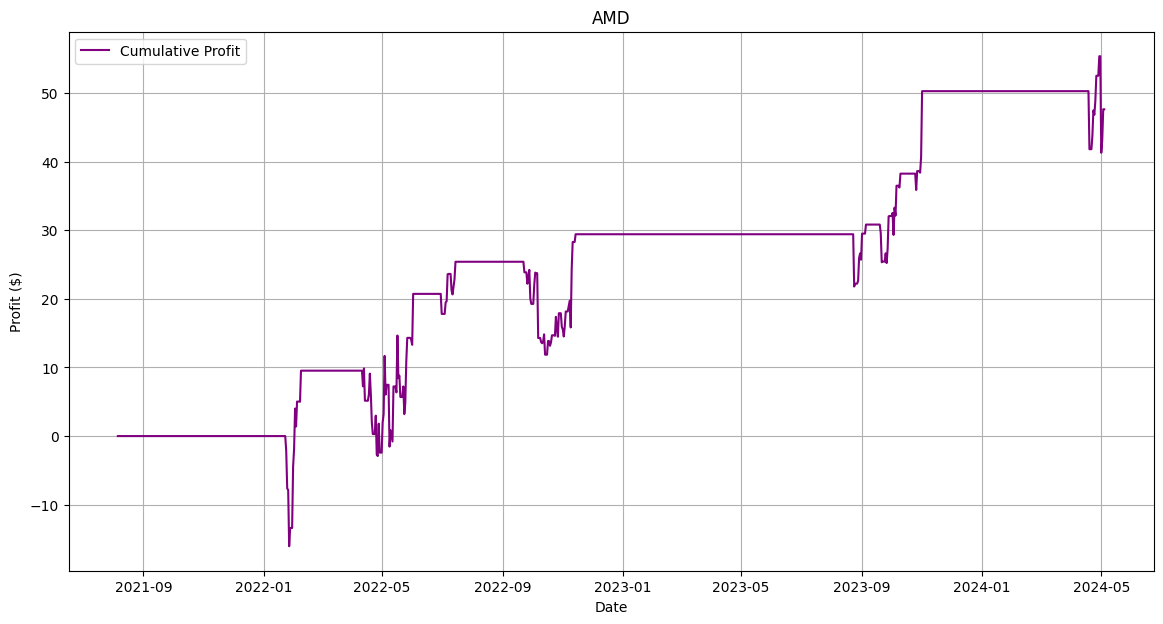

Final cumulative profit: 47.620000000000005


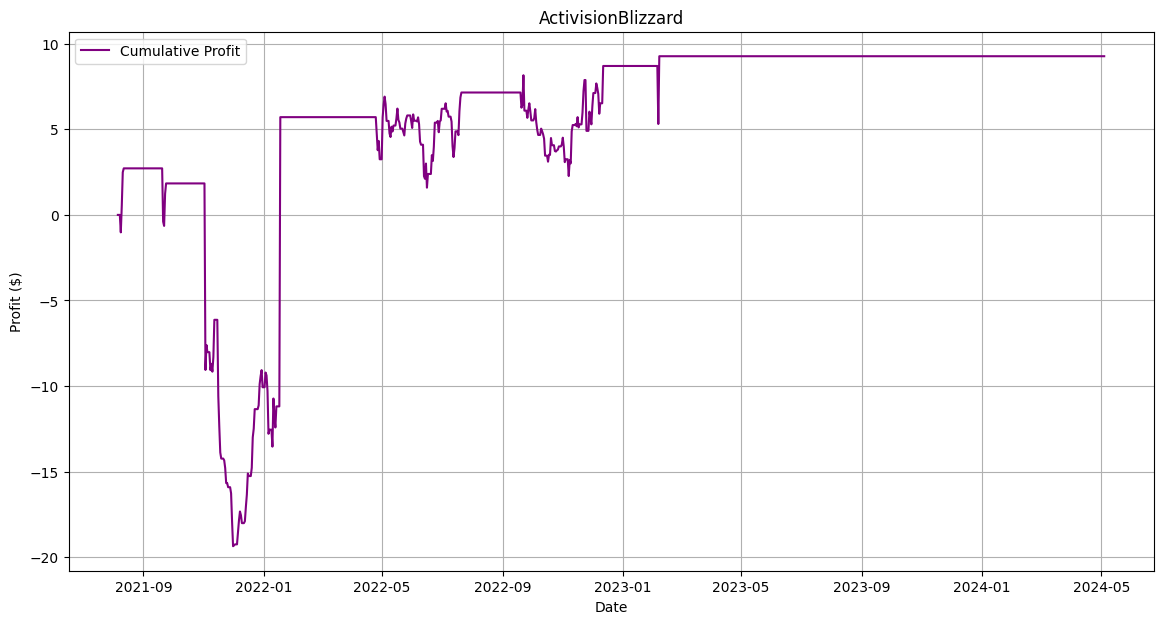

Final cumulative profit: 9.270999999999972


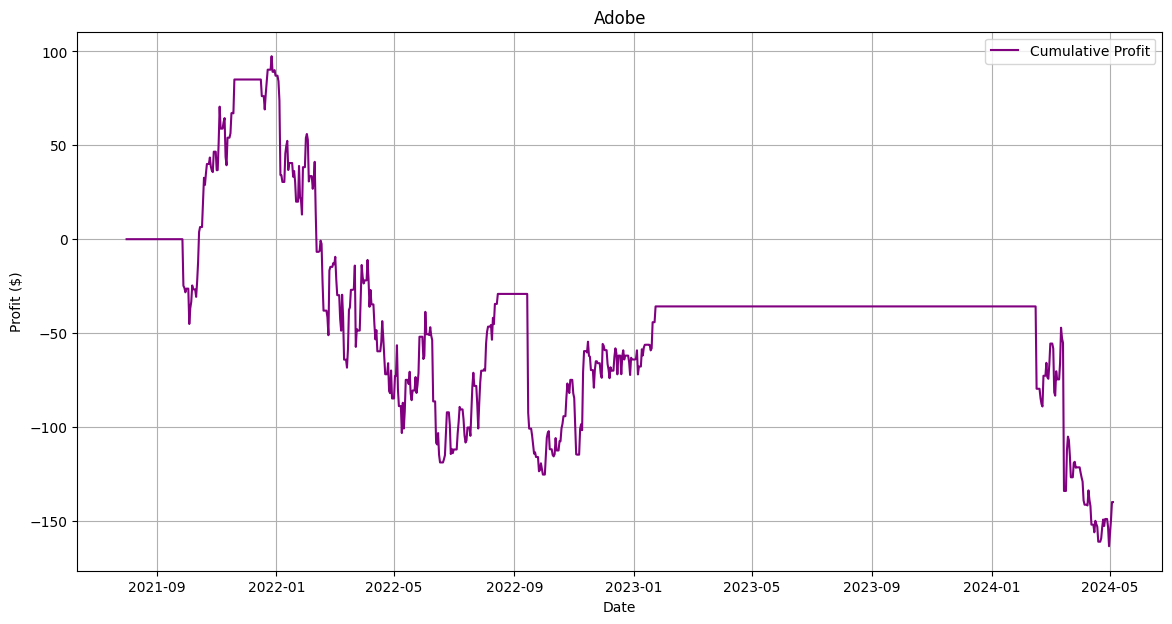

Final cumulative profit: -140.041


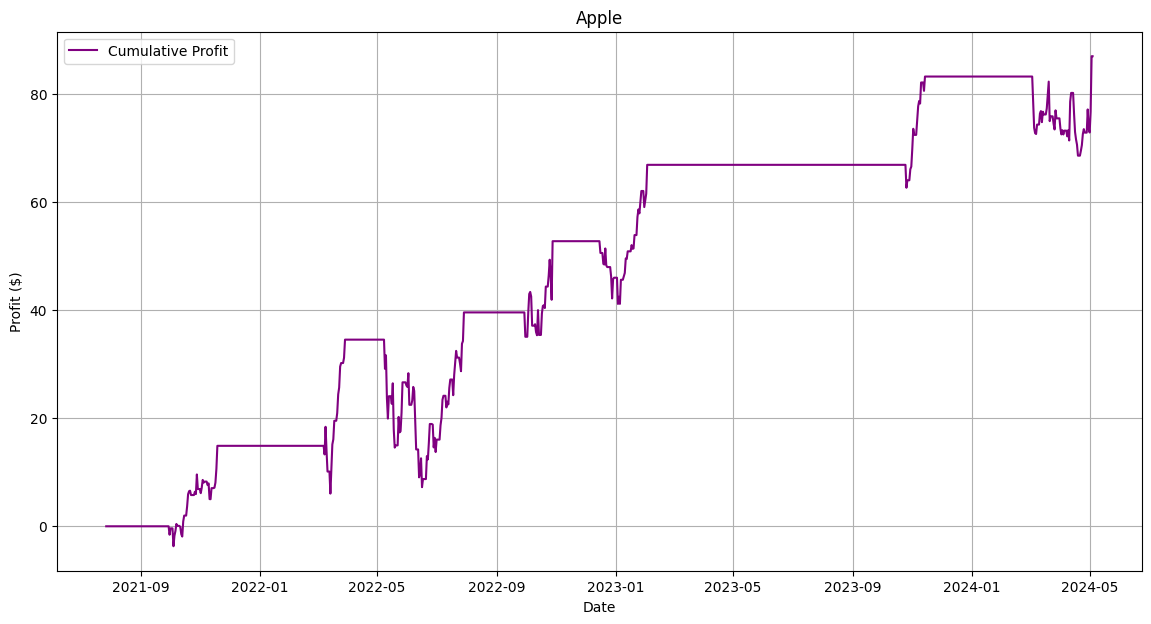

Final cumulative profit: 86.98899999999998


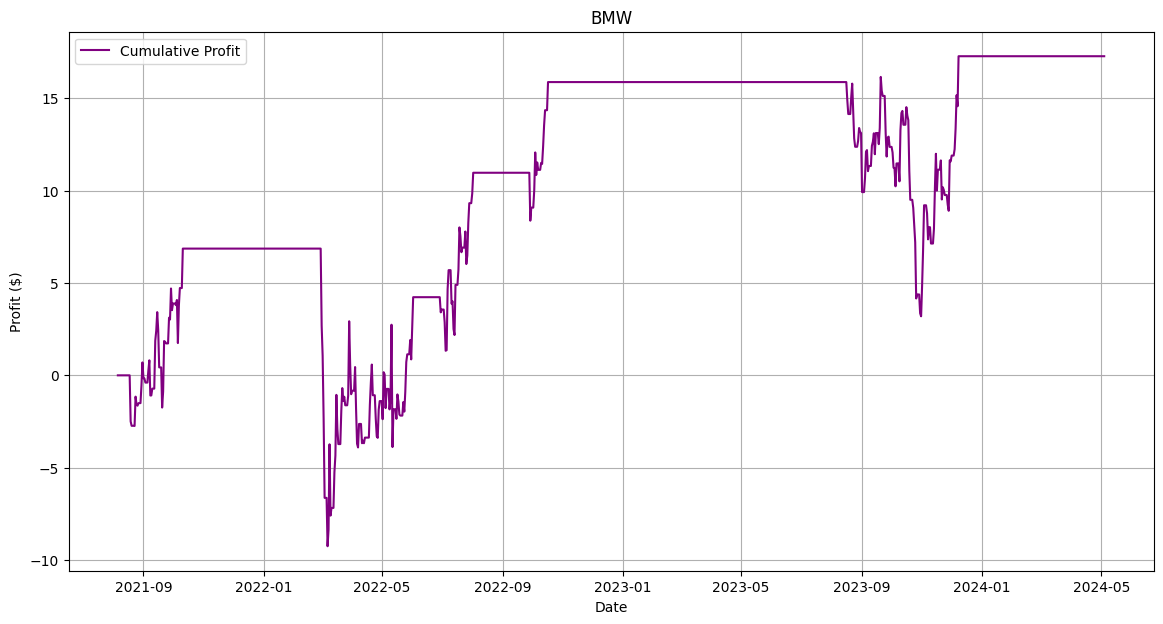

Final cumulative profit: 17.267999999999986


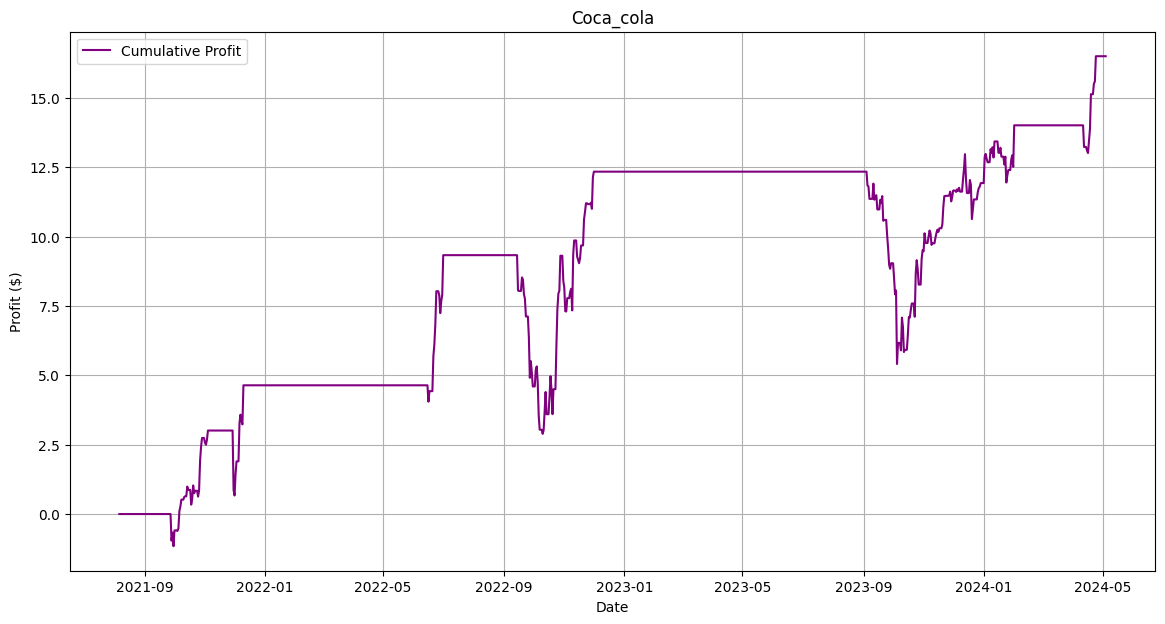

Final cumulative profit: 16.498000000000005


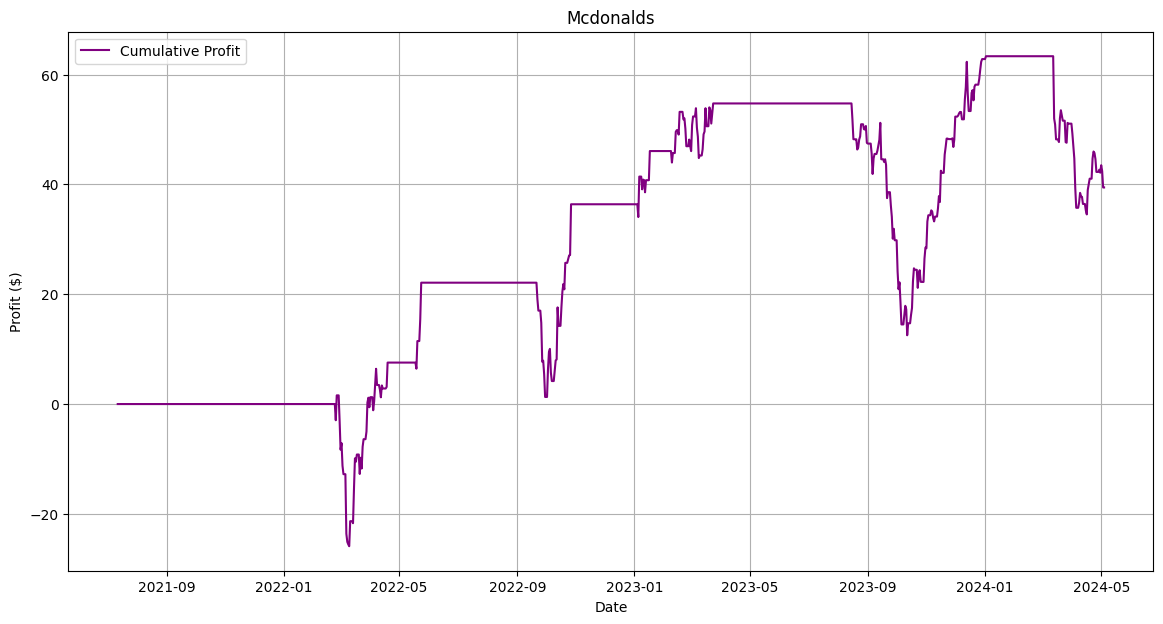

Final cumulative profit: 39.43500000000006


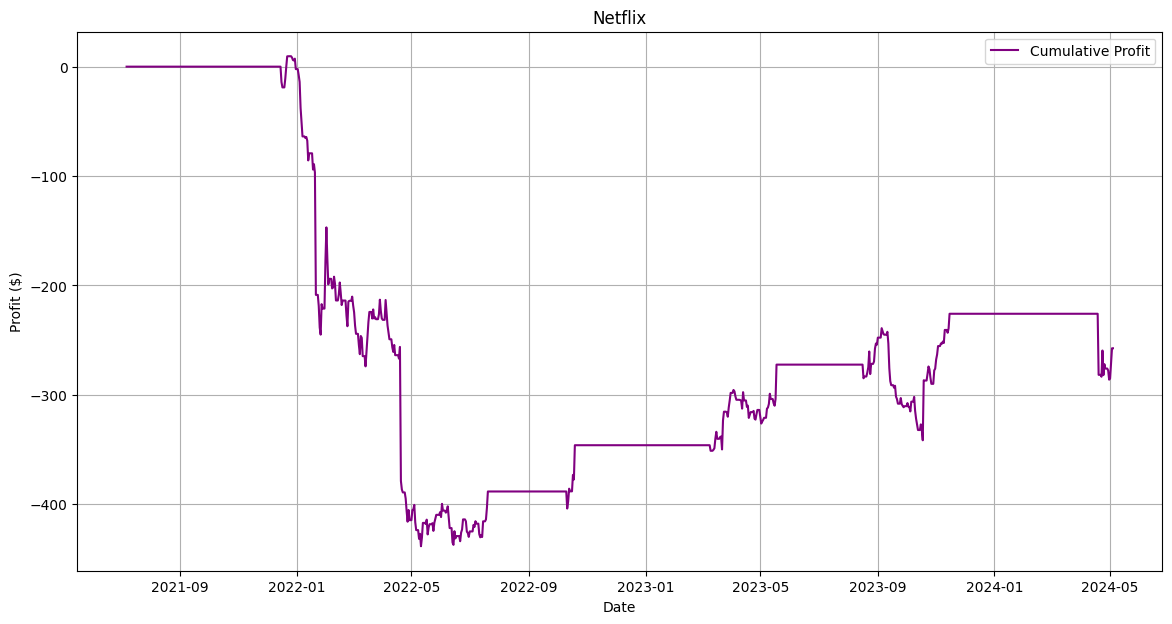

Final cumulative profit: -257.43399999999946


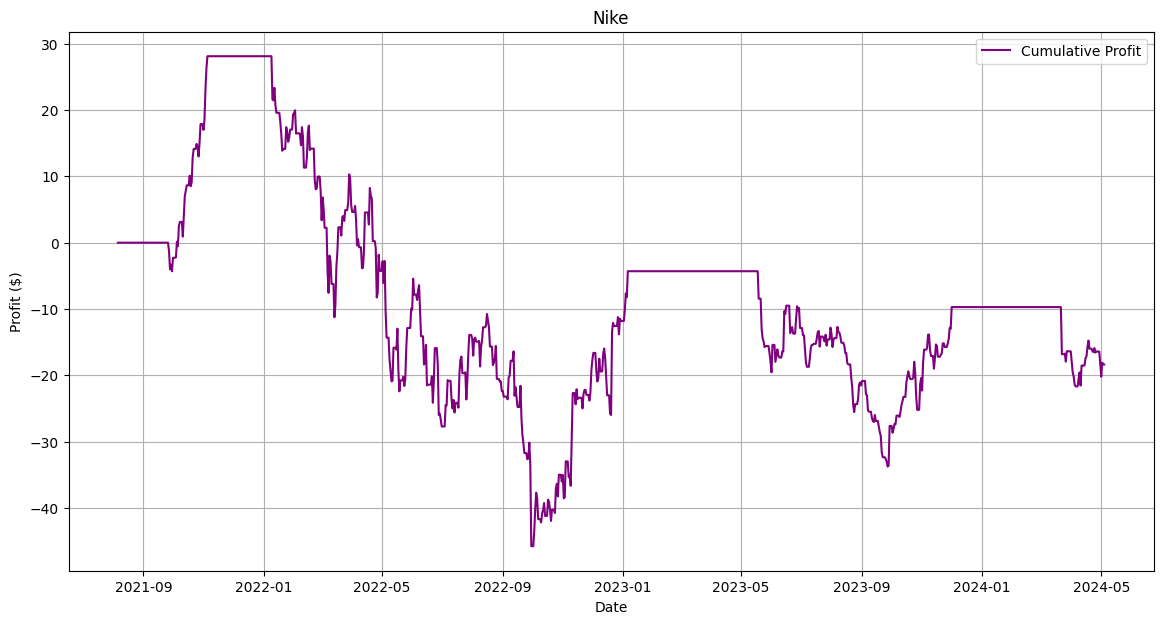

Final cumulative profit: -18.370000000000005


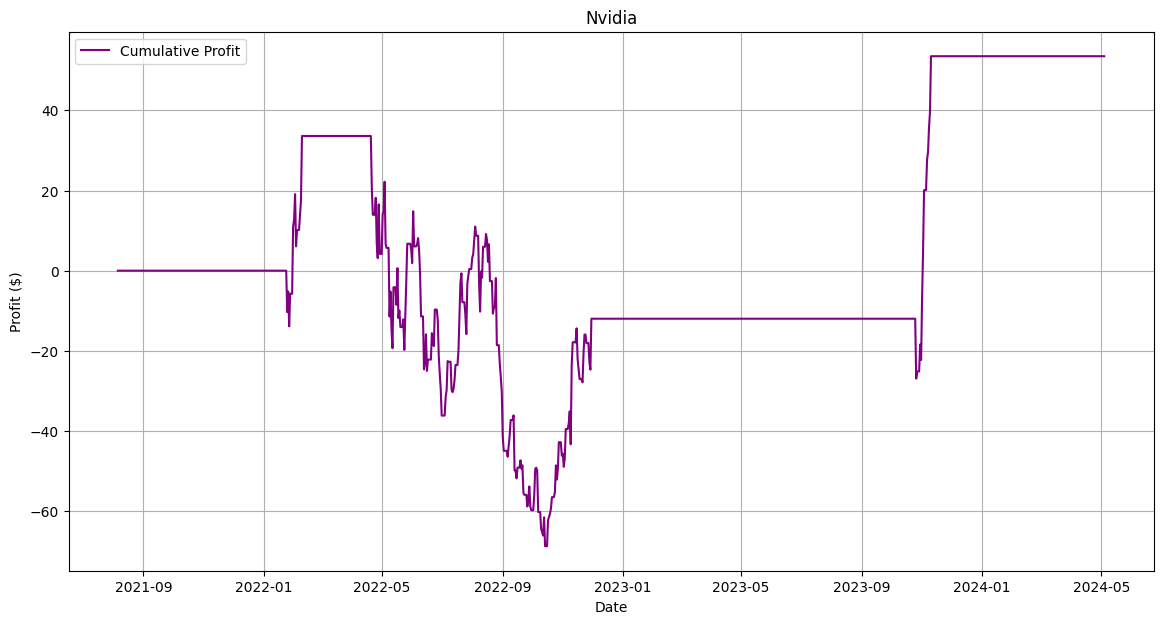

Final cumulative profit: 53.498999999999995


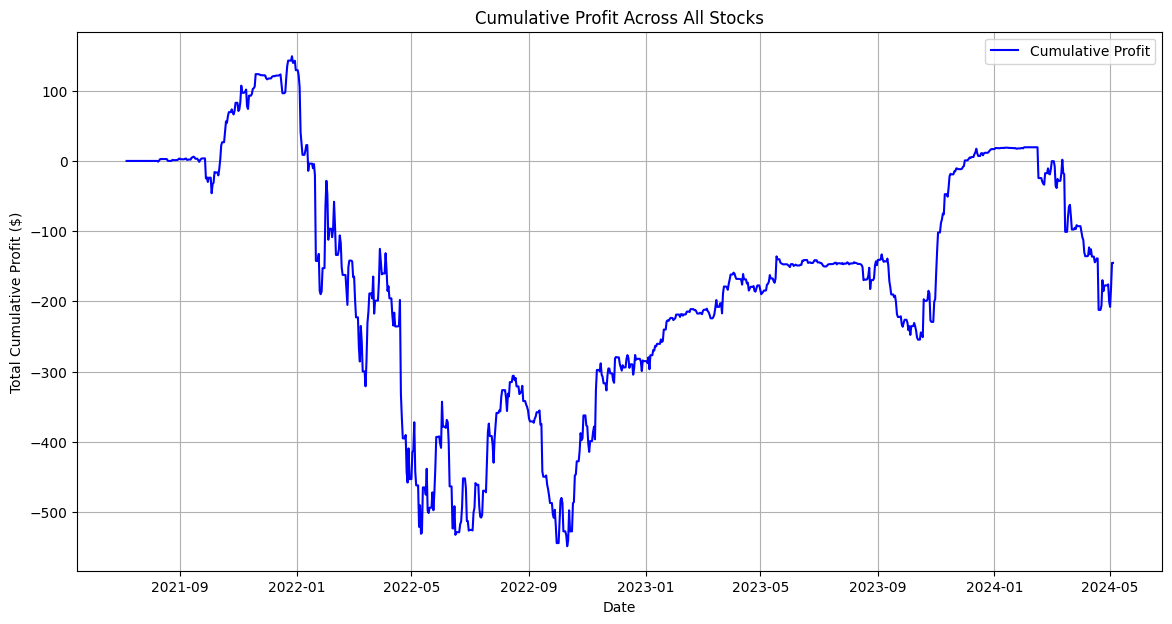

In [ ]:
all_profits = pd.DataFrame()
all_returns = []

for file_path in file_paths:
    file_name = os.path.splitext(os.path.basename(file_path))[0]
    window, profit_percent = best_params[file_name][0], best_params[file_name][1]

    data = read_and_calculate_indicators(file_path, window)
    data = clean_data(data)
    _, _, _, _, cumulative_profit, _, returns = generate_signals(data, 0.0005, profit_percent)


    profits_df = pd.DataFrame(cumulative_profit, index=data.index, columns=[file_name])
    all_returns.append(returns)

    if all_profits.empty:
        all_profits = profits_df
    else:
        all_profits = all_profits.join(profits_df, how='outer')

    plot_profits(data, cumulative_profit, file_name)
    print("Final cumulative profit:", cumulative_profit[-1])


all_profits['Total Profit'] = all_profits.sum(axis=1)


plt.figure(figsize=(14, 7))
plt.plot(all_profits.index, all_profits['Total Profit'], label='Cumulative Profit', color='blue')
plt.title("Cumulative Profit Across All Stocks")
plt.xlabel('Date')
plt.ylabel('Total Cumulative Profit ($)')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
!pip install seaborn

      AMD  ActivisionBlizzard  Adobe  Apple  BMW  Coca_cola  Mcdonalds  \
0     0.0               0.000    0.0    0.0  0.0        0.0        0.0   
1     0.0               0.000    0.0    0.0  0.0        0.0        0.0   
2     0.0               0.000    0.0    0.0  0.0        0.0        0.0   
3     0.0              -1.020    0.0    0.0  0.0        0.0        0.0   
4     0.0               1.559    0.0    0.0  0.0        0.0        0.0   
...   ...                 ...    ...    ...  ...        ...        ...   
1028  NaN                 NaN    NaN    NaN  NaN        NaN        NaN   
1029  NaN                 NaN    NaN    NaN  NaN        NaN        NaN   
1030  NaN                 NaN    NaN    NaN  NaN        NaN        NaN   
1031  NaN                 NaN    NaN    NaN  NaN        NaN        NaN   
1032  NaN                 NaN    NaN    NaN  NaN        NaN        NaN   

      Netflix  Nike  Nvidia  
0       0.000   0.0     0.0  
1       0.000   0.0     0.0  
2       0.000   0.0  

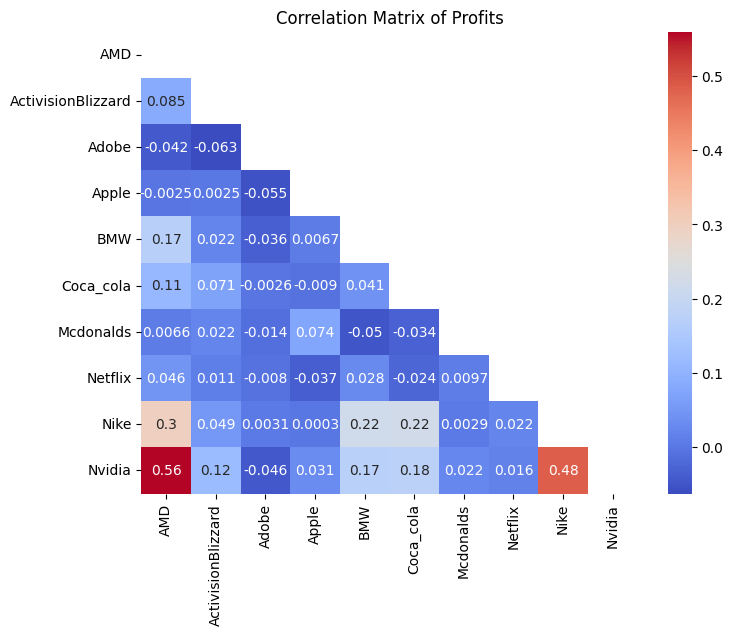

In [ ]:
import seaborn as sns

filenames = [os.path.basename(file_path).split('.')[0] for file_path in file_paths]

profit_df = pd.DataFrame(all_returns, index = filenames).transpose()

print(profit_df)
correlation_matrix = profit_df.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype = bool))

plt.figure(figsize = (8, 6))

sns.heatmap(correlation_matrix, mask = mask, annot = True, cbar = True, cmap = 'coolwarm')

plt.title('Correlation Matrix of Profits')
plt.show()